In [1]:
from datasets import load_dataset

# 1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [2]:
from tensorflow.keras import layers

# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [3]:
import numpy as np
import tensorflow as tf

def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0 # Normalisasi 0-1
    # Proses Teks
    caption = item['text']
    return caption, image

# Membuat generator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [4]:
import tensorflow as tf
from tensorflow import keras

class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # 1. Ubah gambar asli menjadi token visual menggunakan encoder
        # Kita simulasikan dengan output dummy sesuai ukuran latent grid (misal 16x16)
        visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

        # 2. Siapkan input dan target (Autoregressive)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]
        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Slice preds to match vis_target sequence length
            preds_for_loss = preds[:, seq_len:, :]
            # Hitung Loss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds_for_loss, from_logits=True)
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Placeholder for VQVAE Encoder
# In a real scenario, this would be a complex model extracting visual features.
class VQVAEEncoder(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv_block = keras.Sequential([
            layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            layers.Flatten()
        ])
        # Simulate a latent space representation (e.g., 256 dimensions)
        self.dense = layers.Dense(256)

    def call(self, inputs):
        x = self.conv_block(inputs)
        return self.dense(x)

# Placeholder for Transformer Model
# This model will take text tokens and visual tokens to predict the next visual token.
class Transformer(keras.Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, seq_len):
        super().__init__()
        self.token_embeddings = layers.Embedding(vocab_size, embed_dim)
        # Position embeddings need to cover the combined sequence length (text + visual input)
        # Here, visual_input_tokens has length 255 (256 visual tokens - 1 for target)
        self.position_embeddings = layers.Embedding(seq_len + 255, embed_dim) # Adjusted input_dim
        # Create the visual token embedding layer once in __init__
        self.visual_token_embeddings = layers.Embedding(1024, embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_transformer_blocks)
        ]
        self.dropout = layers.Dropout(0.1)
        self.final_layer = layers.Dense(1024) # Output size should match visual token vocabulary size

    def call(self, inputs, training):
        text_tokens, visual_input_tokens = inputs

        # Process text tokens
        text_embed = self.token_embeddings(text_tokens)

        # Use the pre-created visual token embedding layer
        visual_embed = self.visual_token_embeddings(visual_input_tokens)

        # Concatenate text and visual embeddings
        # This is a simplification; a real model might use cross-attention
        combined_embed = tf.concat([text_embed, visual_embed], axis=1)

        # Add positional embeddings
        positions = tf.range(start=0, limit=tf.shape(combined_embed)[1], delta=1)
        position_embed = self.position_embeddings(positions)
        x = combined_embed + position_embed

        x = self.dropout(x, training=training)

        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)

        return self.final_layer(x)

# Helper class for Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Instantiate the placeholder models
# You will need to determine appropriate values for these parameters
vocab_size = len(vocab)  # Using the vocabulary size from text_vectorizer
embed_dim = 256 # Embedding dimension for both text and visual tokens
num_heads = 4 # Number of attention heads
ff_dim = 512 # Hidden layer size in feed forward network
num_transformer_blocks = 2 # Number of transformer blocks

vqvae_encoder = VQVAEEncoder()
transformer_model = Transformer(vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, seq_len)

print("Placeholder models 'vqvae_encoder' and 'transformer_model' created.")

Placeholder models 'vqvae_encoder' and 'transformer_model' created.


In [8]:
# Inisialisasi dan Training
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print("Memulai Pelatihan (1 Epoch untuk demo)...")
trainer.fit(train_ds.take(10), epochs=50)

Memulai Pelatihan (1 Epoch untuk demo)...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - loss: 7.1069
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 7.0744
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 7.0258
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 6.9896
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 6.9656
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 813ms/step - loss: 6.9587
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 6.9536
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 6.9525
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 6.9482
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 6.9482
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 6.9468
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 6.9470
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 6.9477
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 6.9455
Epoch 15/50
10

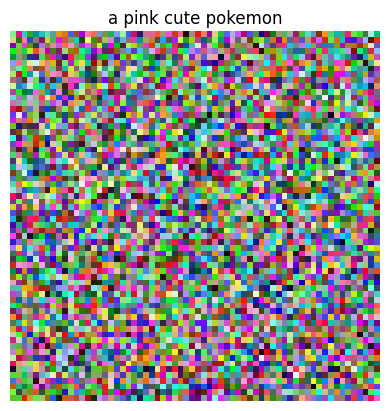

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Placeholder for generate_image_tokens
def generate_image_tokens(transformer_model, text_tokens, num_visual_tokens, visual_vocab_size):
    # Simulate generation of visual tokens
    # In a real scenario, this would involve autoregressive sampling from the transformer
    return tf.random.uniform((tf.shape(text_tokens)[0], num_visual_tokens), minval=0, maxval=visual_vocab_size - 1, dtype=tf.int32)

# Placeholder for decode_to_real_image
def decode_to_real_image(visual_tokens):
    # Simulate decoding visual tokens back to an image
    # In a real scenario, this would involve a VQVAE decoder
    # For now, return a dummy image (e.g., a simple colored square)
    dummy_image = tf.random.uniform((64, 64, 3), minval=0, maxval=1.0, dtype=tf.float32)
    return dummy_image

def generate_pokemon(prompt):
    # 1. Ubah teks ke angka
    tokenized_text = text_vectorizer([prompt])
    # 2. Generate token visual (Autoregressive)
    # Gunakan fungsi generate_image_tokens yang kita buat sebelumnya
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, 1024)
    # 3. Decode jadi Gambar menggunakan Pre-trained VAE
    # Gunakan fungsi decode_to_real_image yang memanggil AutoencoderKL
    final_image = decode_to_real_image(gen_vis_tokens)
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()
# TEST
generate_pokemon("a pink cute pokemon")